In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans # k-means
from sklearn.pipeline import Pipeline

from sklearn.metrics import silhouette_score

%matplotlib inline

#https://www.kaggle.com/geomack/spotifyclassification

In [2]:
spotify = pd.read_csv('Spotify.csv')

In [3]:
spotify.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [4]:
spotify.drop(spotify.columns[0], axis='columns', inplace=True)

In [5]:
spotify.shape

(2017, 16)

In [6]:
predictors = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
              'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'target']

z = StandardScaler()

#spotify[predictors] = z.fit_transform(X)

## Principle Component Analysis

In [7]:
pca = PCA()
pca.fit(spotify[predictors])

pcaDF = pd.DataFrame({'expl_var': pca.explained_variance_ratio_, 
                      'component': range(1,15), 
                      'cum_variance': pca.explained_variance_ratio_.cumsum()})

pcaDF

,expl_var,component,cum_variance
0,9.999999e-01,1,1.0
1,1.053787e-07,2,1.0
2,2.057192e-09,3,1.0
3,1.836153e-09,4,1.0
4,3.824994e-11,5,1.0
5,3.261160e-11,6,1.0
6,1.123520e-11,7,1.0
7,9.575236e-12,8,1.0
8,7.822013e-12,9,1.0
9,6.417133e-12,10,1.0


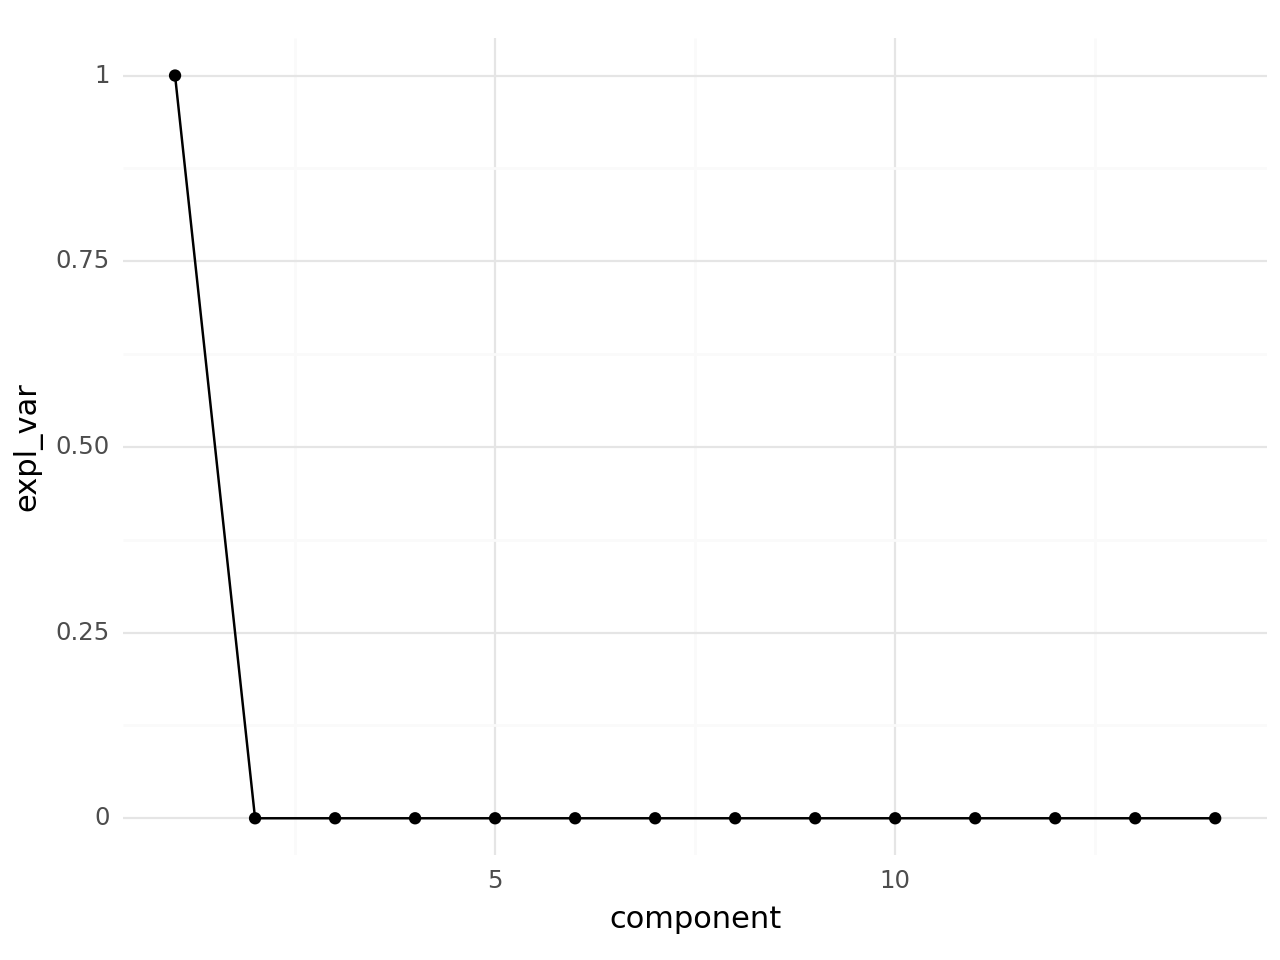

<Figure Size: (640 x 480)>

In [8]:
ggplot(pcaDF, aes(x = 'component', y = 'expl_var')) + geom_line() + geom_point() + theme_minimal()

In [9]:
spotify_pca = pca.transform(spotify[predictors])
spotify_pca = pd.DataFrame(spotify_pca[:, 1:3])
spotify_pca

,0,1
0,27.351406,4.439048
1,40.406036,5.599410
2,-48.093209,2.328595
3,-36.468260,4.922196
4,55.982178,2.943117
...,...,...
2012,-45.867243,0.359510
2013,-13.110958,1.016627
2014,27.548484,2.202353
2015,26.935761,1.707810


## KMeans Clustering

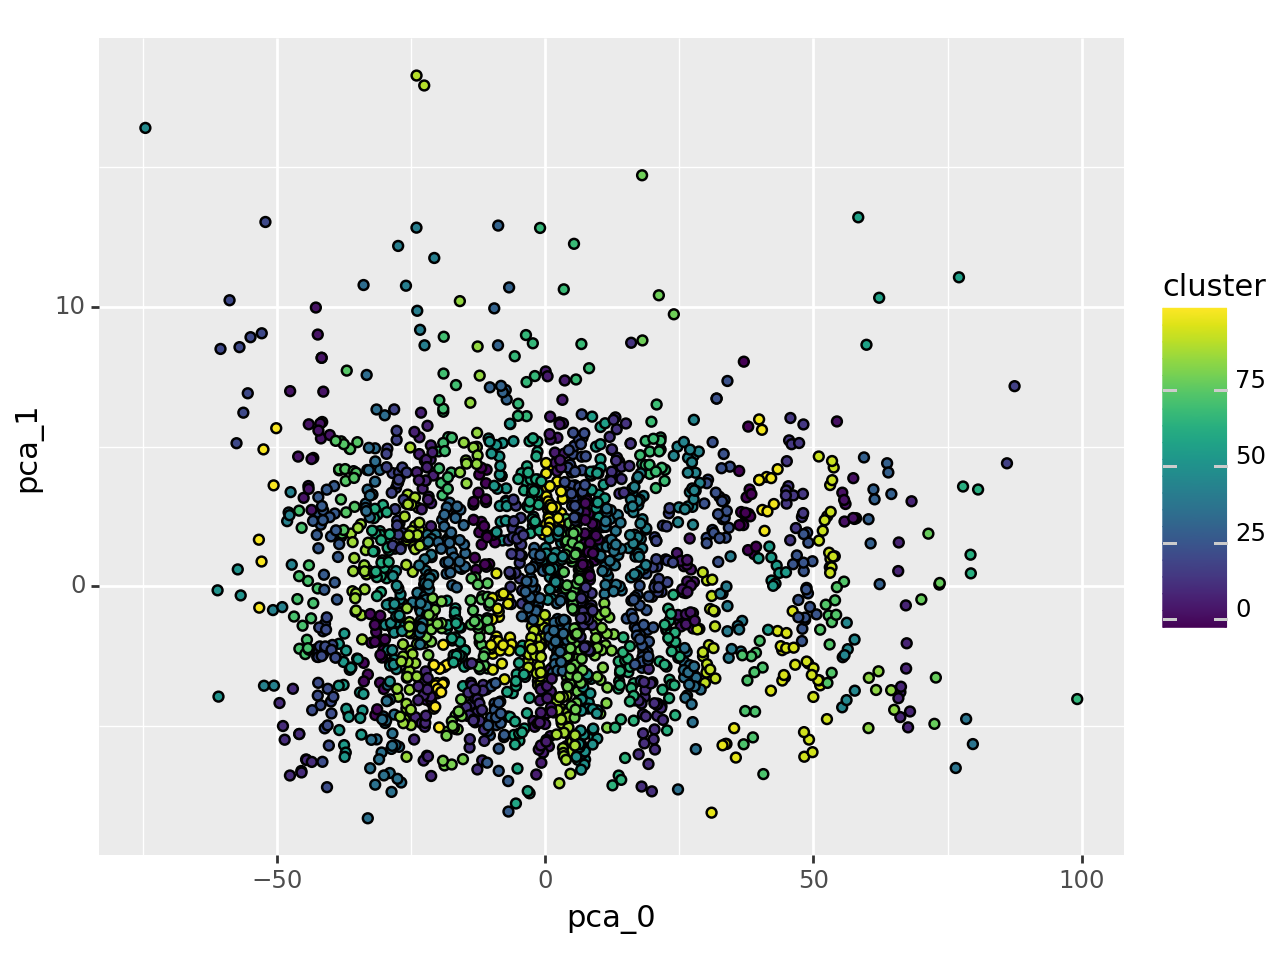

<Figure Size: (640 x 480)>

In [10]:
km = KMeans(n_clusters = 100)
km.fit(spotify_pca)

membership = km.predict(spotify_pca)

spotify_pca['cluster'] = membership

spotify_pca = spotify_pca.rename({1 : 'pca_1', 0 : 'pca_0'}, axis = 1)
ggplot(spotify_pca, aes(x = 'pca_0', y = 'pca_1', fill = 'cluster')) + geom_point()

In [11]:
silhouette_score(spotify_pca, membership)

0.7680514738278421

### Optimizing parameters for K-Means model

In [12]:
#finding the best value for K (number of clusters)
ks = [2,5,10,20,30,50,75,100,125,150,200]

sse = []
sils = []

for k in ks:
    km = KMeans(n_clusters = k)
    km.fit(spotify_pca)
    
    sse.append(km.inertia_)
    sils.append(silhouette_score(spotify_pca, km.predict(spotify_pca)))
    
sse_df = pd.DataFrame({'K': ks, 'sse': sse, 'silhouette': sils})

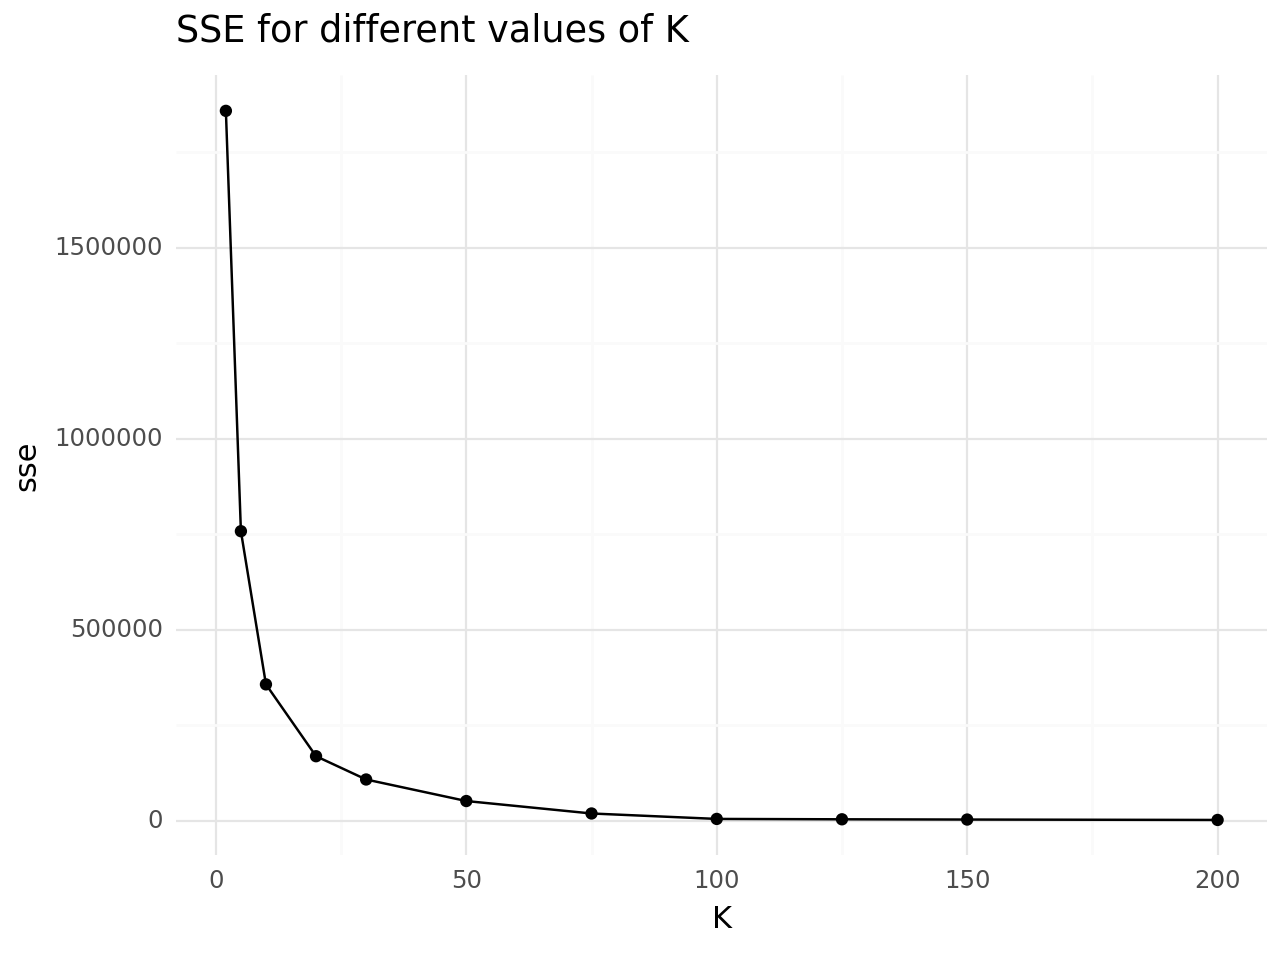

<Figure Size: (640 x 480)>

In [13]:
(ggplot(sse_df, aes(x = 'K', y = 'sse')) + 
geom_point() + 
geom_line() + 
theme_minimal() +
labs(title = 'SSE for different values of K'))

### The higher the value of K, the lower the sum of squared errors becomes. After a K value of 50 there is not a noticable difference in sse.

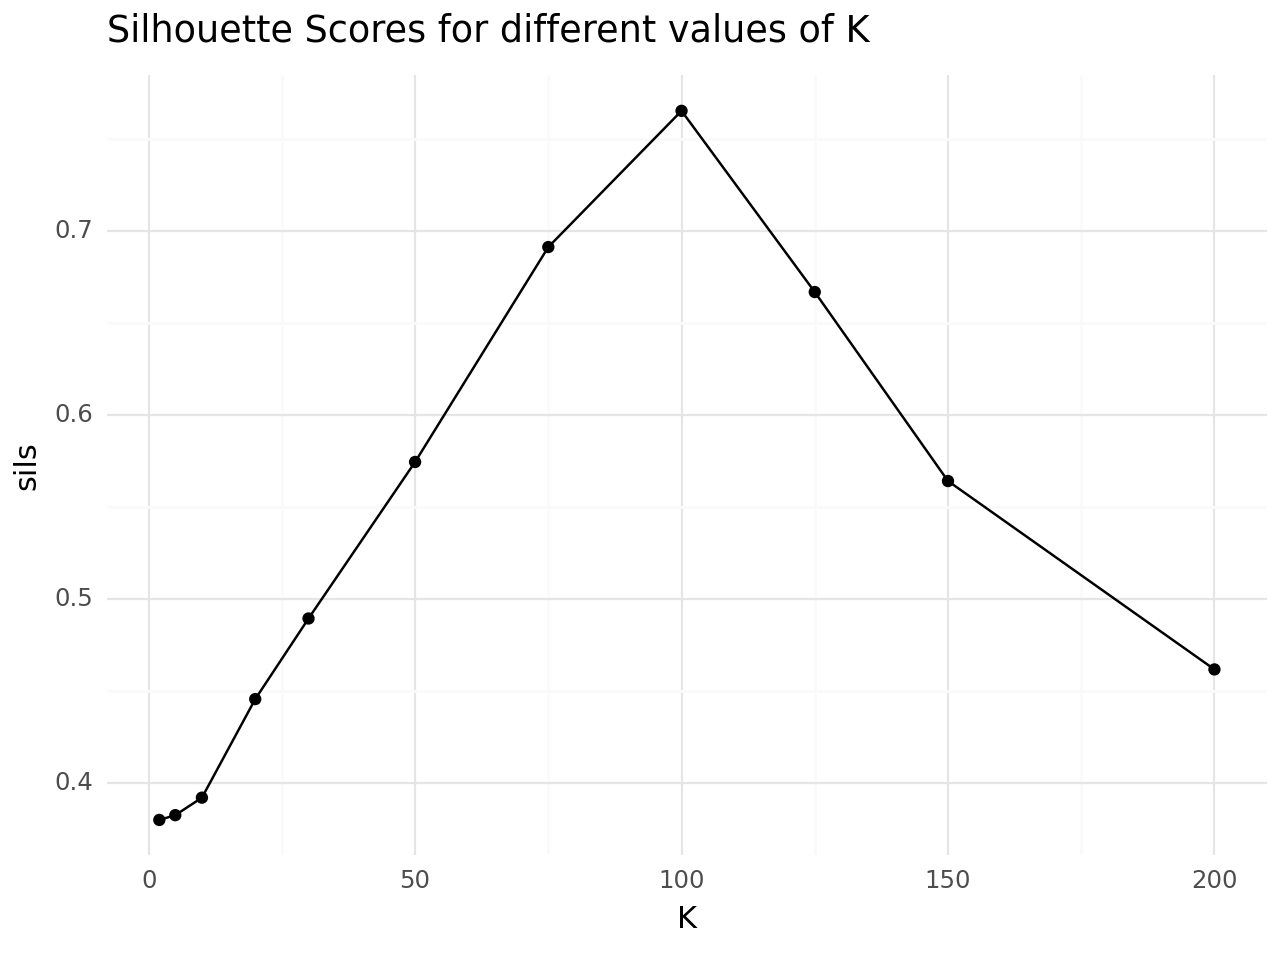

<Figure Size: (640 x 480)>

In [14]:
(ggplot(sse_df, aes(x = 'K', y = 'sils')) + 
geom_point() + 
geom_line() + 
theme_minimal() +
labs(title = 'Silhouette Scores for different values of K'))

### K = 100 is produces the highest silhouette score

# Results

In [15]:
#appending song title and artist to the database
spotify_pca['song_title'] = spotify['song_title']
spotify_pca['artist'] = spotify['artist']

spotify_pca

,pca_0,pca_1,cluster,song_title,artist
0,27.351406,4.439048,45,Mask Off,Future
1,40.406036,5.599410,97,Redbone,Childish Gambino
2,-48.093209,2.328595,43,Xanny Family,Future
3,-36.468260,4.922196,73,Master Of None,Beach House
4,55.982178,2.943117,4,Parallel Lines,Junior Boys
...,...,...,...,...,...
2012,-45.867243,0.359510,70,Like A Bitch - Kill The Noise Remix,Kill The Noise
2013,-13.110958,1.016627,1,Candy,Dillon Francis
2014,27.548484,2.202353,45,Habit - Dack Janiels & Wenzday Remix,Rain Man
2015,26.935761,1.707810,6,First Contact,Twin Moons


In [16]:
#takes input from the user and returns reccomendations
def getReccomendations():
    
    num_cluster = 0
    
    #takes input from user
    print('Enter the name of an artist')
    artist = input(str('>> '))
    print('Eter the name of their song')
    song = input(str('>> '))

    #finds cluster value of song
    try:
        for i in range(len(spotify_pca)):
            if spotify_pca['artist'].iloc[i] == artist and spotify_pca['song_title'].iloc[i] == song:
                num_cluster = spotify_pca['cluster'].iloc[i]
    except KeyError:
        print('Error: Artist/Song not in database')
    #outputs all songs in the cluster
    finally:
        for i in range(len(spotify_pca)):
            if spotify_pca['cluster'].iloc[i] == num_cluster:
                print(spotify_pca['artist'].iloc[i], ', ', spotify_pca['song_title'].iloc[i])
                
getReccomendations()

Enter the name of an artist
Eter the name of their song
Drake ,  Sneakin’
Nina Simone ,  I Shall Be Released - Remastered
Allie X ,  Bitch
Zapp ,  Computer Love
Drake ,  Started From the Bottom
Riff Raff ,  Marc Jacobs
ASTR ,  R U With Me
TV On The Radio ,  DLZ
Drake ,  Skepta Interlude
Brett Young ,  Sleep Without You
Charlie Worsham ,  Cut Your Groove
Darius Rucker ,  If I Told You
JAY Z ,  Clique
Chris Tomlin ,  Home
Ryan Stevenson ,  Eye of the Storm (feat. Gabe Real)
Big Brain ,  Love, Love.
Rick Ross ,  Powers That Be
Total ,  Can't You See
Fort Minor ,  Remember The Name (feat. Styles Of Beyond)
Bassnectar ,  Mind Tricks
Charice ,  Pyramid (feat. Iyaz)
Sabrina Carpenter ,  Eyes Wide Open
Alanis Morissette ,  Ironic


In [30]:
# Calculate the silhouette score for clustering quality
# silhouette_avg = silhouette_score(spotify_pca.iloc[:, :-2], membership)

# Print the silhouette score
# print("Silhouette Score:", silhouette_avg)



Silhouette Score: 0.7680514738278421
